# K-means
---

In [1]:
%matplotlib notebook

## Imports

In [92]:
import math
import matplotlib.colors as mcolors
import matplotlib.markers as mmarkers

from collections import Counter
from itertools import chain, combinations, groupby, zip_longest 
from matplotlib import pyplot as plt
from operator import itemgetter
from random import randrange, random, sample
from scipy.spatial import KDTree
from statistics import mean, median

from typing import Callable, List, Tuple

## Algorithm

In [3]:
def __euclidean_squared_distance(p: Tuple, q: Tuple) -> float:
    """The square of Euclidean distance between 2 points.

    Args:
        p: One of the points whose distance will be computed.
        q: One of the points whose distance will be computed.

    Returns:
        A floating point value for the Euclidean distance between the two arguments.
    """
    dim = len(p)
    return sum([(p[i] - q[i]) ** 2 for i in range(dim)])

In [4]:
def __group_points_by_cluster(points: List[Tuple], cluster_indices: List[int]) -> List[List[Tuple]]:
    """Takes a list of points and another list with their cluster_indices, groups the points by cluster_indices and
       returns the list of points.

    Args:
        points: The list of points to group.
        cluster_indices: The list of cluster indices for the points. Must reflect the order of `points`.

    Returns:
        A list of clusters, where each cluster is a list of points.
    """
    n = len(points)
    get_point_label = lambda i: cluster_indices[i]
    clusters = groupby(sorted(range(n), key=get_point_label), key=get_point_label)
    return [[points[i] for i in group] for _, group in clusters]

In [5]:
def __update_centroids(points: List[Tuple], cluster_indices: List[int]) -> List[Tuple]:
    """Update the centroids for each cluster, by computing the center of mass for the cluster.

    Args:
        points: The list of points to group.
        cluster_indices: The list of cluster indices for the points. Must reflect the order of `points`.

    Returns:
        The list of centroids for each cluster. The point at index `i` is the centroid for the `i`-th cluster.
    """
    dim = len(points[0])
    clusters = __group_points_by_cluster(points, cluster_indices)
    return [tuple(mean([p[j] for p in C]) for j in range(dim)) for C in clusters]

In [6]:
def __add_or_subtract_random_five_percent(p: Tuple[float]):
    """Given a point (a tuple of floats), adds +/- 5% to each of its coordinates.
       This allows to get a random point close to a given one.

    Args:
        p: A point to be used as reference.

    Returns:
        A random point close to the point in input (within 5% of each coordinate)
    """
    return [x * (0.95 + random() / 10) for x in p]

In [7]:
def __random_centroid_init(points, k):
    """ Randomly initialize the centroids.
        Chooses k points from the dataset, then for each of them
        and for each coordinate adds or subtracts a random value, within 5% of the coordinate value.
    """
    return [__add_or_subtract_random_five_percent(p) for p in sample(points, k)]

In [20]:
def __partition_points(points: List[Tuple], centroids: List[Tuple]) -> List[int]:
    """Finds the closest centroid to each point by going through all (centroid, data point) pairs and for each computing
       the distance between the two points.

    Args:
        points: The list of points to partition.
        centroids: The list of centroids to which the points will be assigned.

    Returns:
        A list of indices: for each point, the index of the closest centroid.
    """
    n = len(points)
    k = len(centroids)
    result = [0] * n

    for j in range(n):
        min_distance = float('inf')
        index = 0
        for i in range(k):
            distance = __euclidean_squared_distance(points[j], centroids[i])
            if distance < min_distance:
                min_distance = distance
                index = i

        result[j] = index
    return result

In [8]:
def k_means(points: List[Tuple], num_centroids: int, max_iter: int) -> Tuple[List[Tuple[float]], List[int]]:
    """K-means clustering method.

    Args:
        points: A list of points to cluster.
        num_centroids: The desired number of clusters.
        max_iter: The maximum number of iterations of k-mean's main cycle allowed.

    Returns:
        A list of the centroids, and a list of the indices for each point.
    """
    dim = len(points[0])
    centroids = __random_centroid_init(points, num_centroids)
    labels = []
    for _ in range(max_iter):
        new_labels = __group_points_by_cluster(points, centroids)
        # Comparing two lists... be aware of the hidden overhead of this implementation!
        # (hint: takes between 2n and 3n operations, instead of just between 1 and n)
        if Counter(new_labels) == Counter(labels):
            # no update from last iteration: the algorithm converged to a (local) minimum
            break
        else:
            # update labels
            labels = new_labels
        centroids = __update_centroids(points, labels)
    return centroids, labels  

In [9]:
def run_with_restarts(points, k, metric, max_iter, restarts=1):
    best_metric = float('inf')
    best_centroids = []
    for _ in range(restarts):
        centroids, labels = k_means(k, max_iter, metric)
        last_metric = metric(points, centroids)
        if last_metric < best_metric:
            best_metric = last_metric
            best_centroids = centroids
            best_partitioning = labels
    return best_centroids, best_partitioning

## Dataset Creation

In [10]:
def create_spherical_cluster(centroid, radius, n_points):
    def random_point_in_circle():
        alpha = random() * 2 * math.pi
        r = radius * math.sqrt(random())
        # r is dim-dimensional root of radius
        
        x = centroid[0] + r * math.cos(alpha)
        y = centroid[1] + r * math.sin(alpha)
        return (x, y)
                    
    return [random_point_in_circle() for _ in range(n_points)] 

In [11]:
def create_ring_cluster(centroid, inner_radius, outer_radius, n_points):
    def random_point_in_ring():
        alpha = random() * 2 * math.pi
        r = inner_radius + (outer_radius - inner_radius) * math.sqrt(random())
        # r is dim-dimensional root of radius
        
        x = centroid[0] + r * math.cos(alpha)
        y = centroid[1] + r * math.sin(alpha)
        return (x, y)
                    
    return [random_point_in_ring() for _ in range(n_points)]

In [12]:
def create_linear_cluster(centroid, length, n_points, alpha=0):
    delta = length / n_points
    step = 0.
    
    def random_point_in_segment(step, displacement_x):
        x = centroid[0] + step * math.cos(alpha) + displacement_x
        y = centroid[1] + step * math.sin(alpha)
        return (x, y)

    points = []
    for i in range(n_points):
        step += (0.5 + random() / 2) * delta
        for _ in range(randrange(1, 10)):
            displacement_x = random() * delta * 2 - delta
            points.append(random_point_in_segment(step, displacement_x))
            
    return points

In [13]:
def create_spiral_cluster(centroid, radius, n_points):
    a_delta = 10 * math.pi / n_points
    r_delta = radius / n_points  
    s = math.sqrt(radius)

    def random_point_in_spiral(index, alpha):
        x = centroid[0] + index * r_delta * (0.95 + random() * 0.1) * math.cos(alpha) #+ (random() * s - s)
        y = centroid[1] + index * r_delta * (0.95 + random() * 0.1) * math.sin(alpha) #+ (random() * s - s)
        return (x, y)
    
    
    alpha = 0.
    radius = 0.
    points = []
    for i in range(n_points):
        step = 0.1 + random() * 0.4
        alpha += a_delta * step
        for _ in range(randrange(1, 10)):
            points.append(random_point_in_spiral(i, alpha))
            step = random() * 0.1
            alpha += a_delta * step
    return points 

In [14]:
def random_point(radius):
    return (random() * radius - radius / 2, random() * radius - radius / 2)

## Plotting

In [124]:
def plot_points(ax, points, color, marker='o'):
    X, Y = zip(*points)
    ax.plot(X, Y, marker=marker, linestyle='none', markersize=4, markerfacecolor=color, markeredgewidth=0.5, markeredgecolor='k')

def plot_centroid(ax, centroid, color):
    x, y = centroid
    ax.plot([x], [y], c=color, linestyle='none', marker='X', markersize=10, markerfacecolor=color, markeredgewidth=2, markeredgecolor='k')

def plot_clusters(points, labels, centroids, point_markers=[], x_label='', y_label=''):
    fig, ax = plt.subplots()
    fig.suptitle('K-means')
    ax.set_aspect('equal')
    fig.canvas.draw()
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    clusters = __group_points_by_cluster(points, labels)
    colors = list(mcolors.TABLEAU_COLORS.keys())[:len(clusters)]
    for cluster, color, marker in zip_longest(clusters, colors, point_markers, fillvalue='o'):
        plot_points(ax, cluster, color, marker)
    for centroid, color in zip(centroids, colors):
        plot_centroid(ax, centroid, color)

## Experiments
---

### Spherical Clusters

In [16]:
k = 10
data_centroids = [random_point(10) for _ in range(k)]
data_clusters = [create_spherical_cluster(P, 0.25 + random(), randrange(10, 100)) for P in data_centroids]
noise = [random_point(10) for _ in range(50)]


points = [p for C in data_clusters for p in C] + noise

<IPython.core.display.Javascript object>


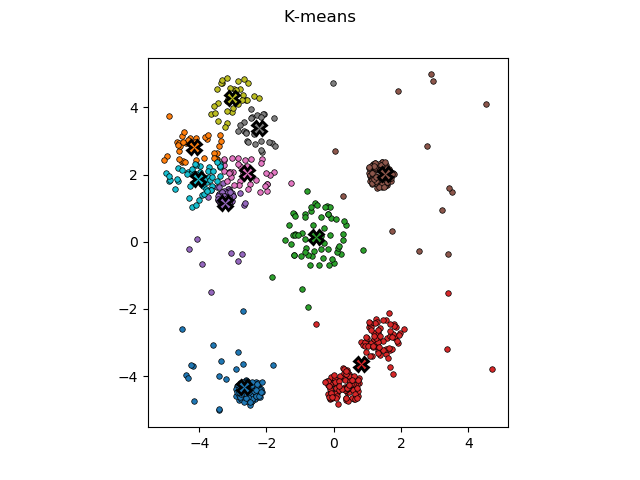

In [21]:
centroids, labels = k_means(points, k, 50)

plot_clusters(points, labels, centroids)

### Rings

In [22]:
data_centroid = random_point(10)

r1 = 0.25 + random()
r2 = r1 + 0.25 * random()
r3 = r2 * 1.1 + random()
r4 = r3 + 0.25 * random()

C1 = create_ring_cluster(data_centroid, r1, r2, randrange(100, 200))
C2 = create_ring_cluster(data_centroid, r3, r4, randrange(200, 300))

points = C1 + C2

In [23]:
centroids_kd, labels_kd = k_means(points, 2, 50)

<IPython.core.display.Javascript object>


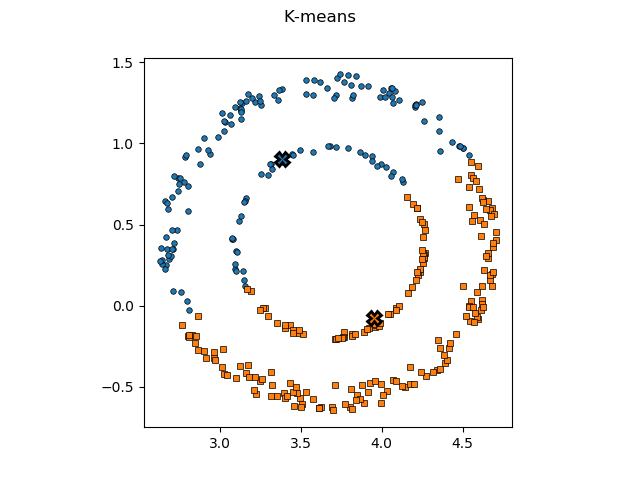

In [24]:
plot_clusters(points, labels_kd, centroids_kd, ['o', 's'])

### Spirals

In [25]:
C3 = create_spiral_cluster(random_point(10), 5, 100)

In [26]:
centroids_kd, labels_kd = k_means(C3, 3, 50)

<IPython.core.display.Javascript object>


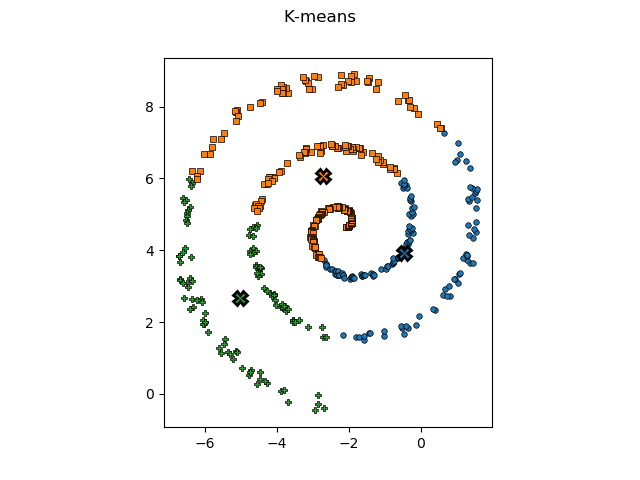

In [27]:
plot_clusters(C3, labels_kd, centroids_kd, ['o', 's', 'P'])

### Segments

In [28]:
P4 = random_point(10)
alpha4 = random() * math.pi / 2
C4 = create_linear_cluster(P4, 5, 100, alpha4) + create_linear_cluster((P4[0] + 1, P4[1]), 4, 100, alpha4 + 0.1)

In [29]:
centroids_kd, labels_kd = k_means(C4, 2, 50)

<IPython.core.display.Javascript object>


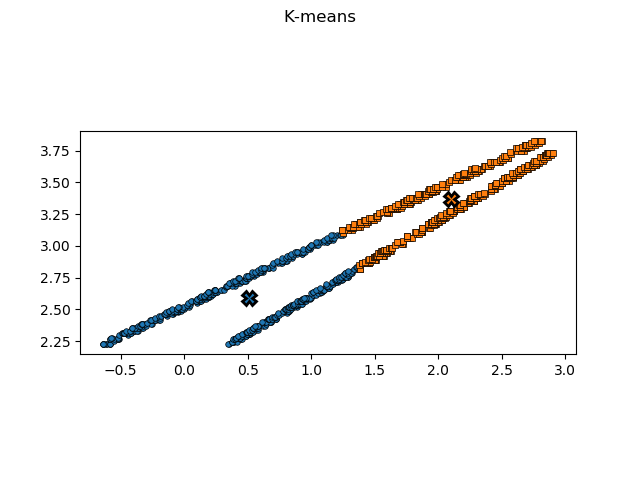

In [119]:
plot_clusters(C4, labels_kd, centroids_kd, ['o', 's'])

## Metrics

In [56]:
def distance_to_cluster_center(points, labels, centroids, distance):
    """ Computes the average distance of points to cluster center. 
    """    
    index_to_label = lambda i: labels[i]
    ## Grouping points by their cluster... in a single line
    clusters = [map(lambda i: points[i], group) for key, group in groupby(sorted(range(len(points)), key=index_to_label), index_to_label)]
    return mean([distance(p, centroids[i]) for i in range(len(clusters)) for p in clusters[i]])

def euclidean_distance_to_cluster_center(points, labels, centroids):
    return distance_to_cluster_center(points, labels, centroids, __euclidean_squared_distance)

In [73]:
def intra_cluster_distance(points, labels, distance):
    """ Computes the average point-to-point intra cluster distance 
    """
    index_to_label = lambda i: labels[i]
    ## Gouping points by cluster
    clusters = __group_points_by_cluster(points, labels)
    return mean([distance(p, q) for C in clusters for (p, q) in combinations(C, 2)])

def euclidean_intra_cluster_distance(points, labels, _=None):
    return intra_cluster_distance(points, labels, __euclidean_squared_distance)

In [82]:
def plot_metrics(k_values, metric_values, title="", x_label="", y_label=""):
    fig, ax = plt.subplots()
    fig.suptitle(title)
    fig.canvas.draw()
    
    ax.plot(k_values, metric_values, 'o-')
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

In [120]:
def elbow_method(k_values, points, metric, max_iter, runs_per_k=1):
    def cluster_and_measure(points, k):
        centroids, labels = k_means(points, num_centroids=k, max_iter=max_iter)
        return metric(points, labels, centroids), labels, centroids
        
#     # Define a scaler object fit on our dataset
#     scaler = StandardScaler().fit(points)
#     # Scale each column independently
#     points_scaled = scaler.transform(points)
    results = [min(map(lambda _: cluster_and_measure(points, k), range(runs_per_k))) for k in k_values]
    plot_metrics(k_values, [r[0] for r in results], 'k-means intra cluster distance', 'k', 'distance')
    
    for _, labels, centroids in results:
        plot_clusters(points, labels, centroids)

In [117]:
k = 6
data_centroids = [random_point(10) for _ in range(k)]
data_clusters = [create_spherical_cluster(P, 0.25 + random() *0.25, randrange(20, 50)) for P in data_centroids]

points_elbow = [p for C in data_clusters for p in C]

<IPython.core.display.Javascript object>


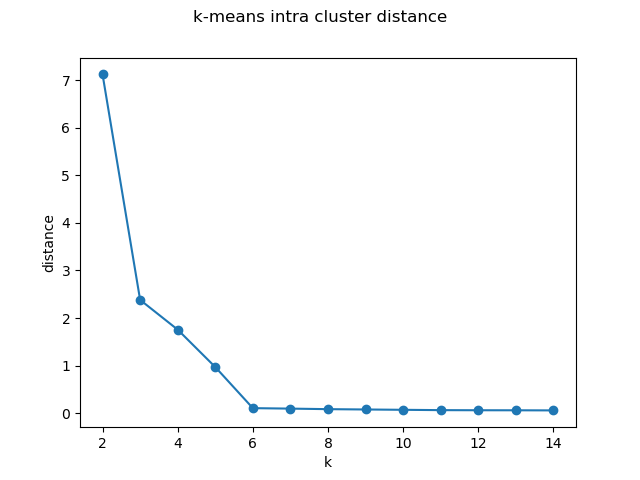

<IPython.core.display.Javascript object>


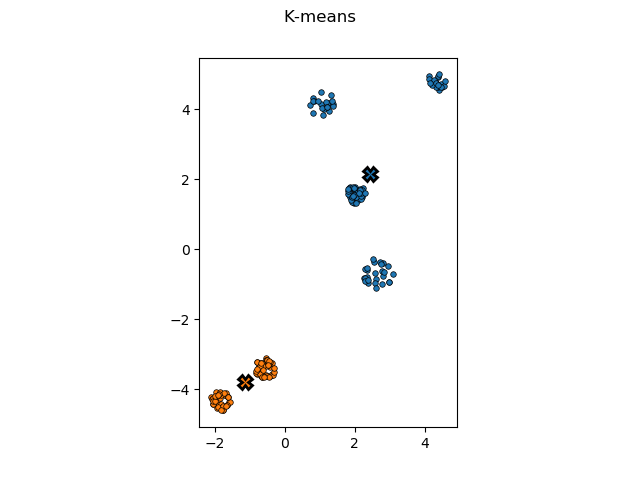

<IPython.core.display.Javascript object>


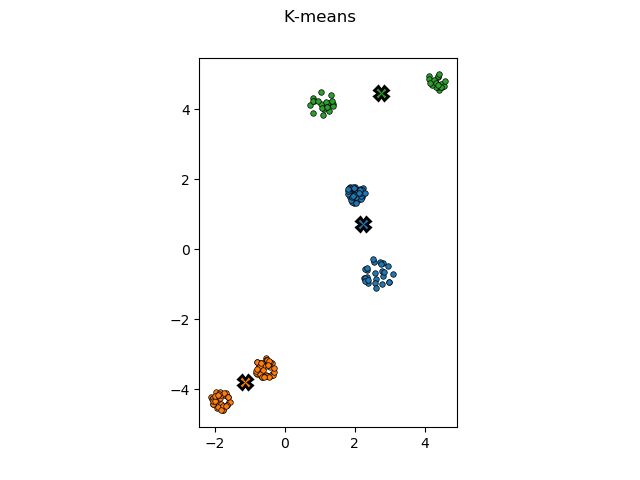

<IPython.core.display.Javascript object>


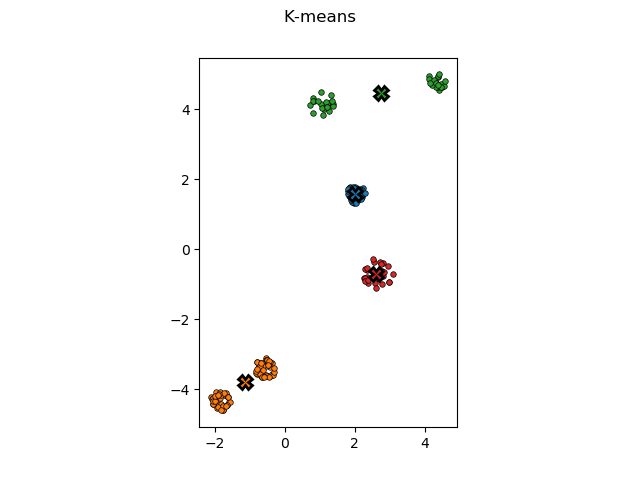

<IPython.core.display.Javascript object>


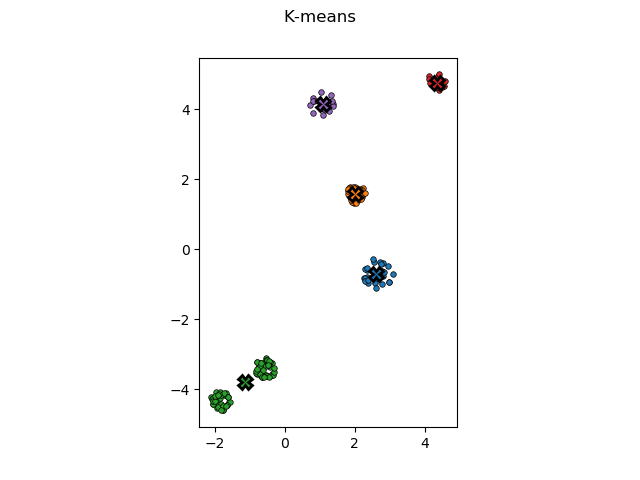

<IPython.core.display.Javascript object>


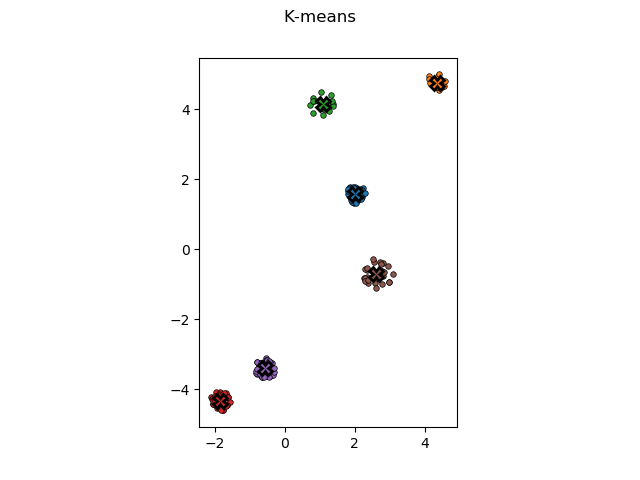

<IPython.core.display.Javascript object>


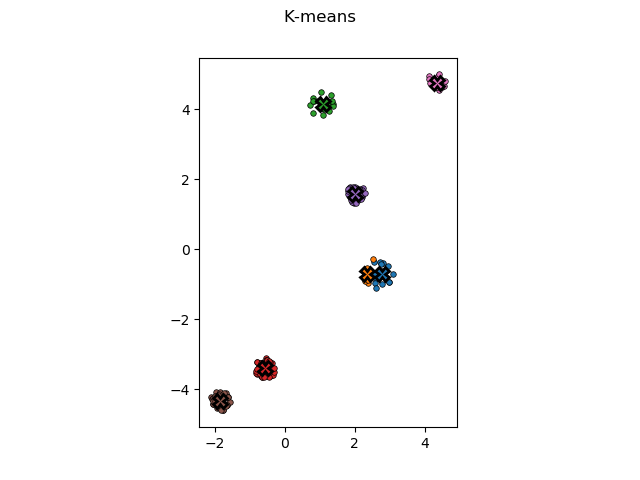

<IPython.core.display.Javascript object>


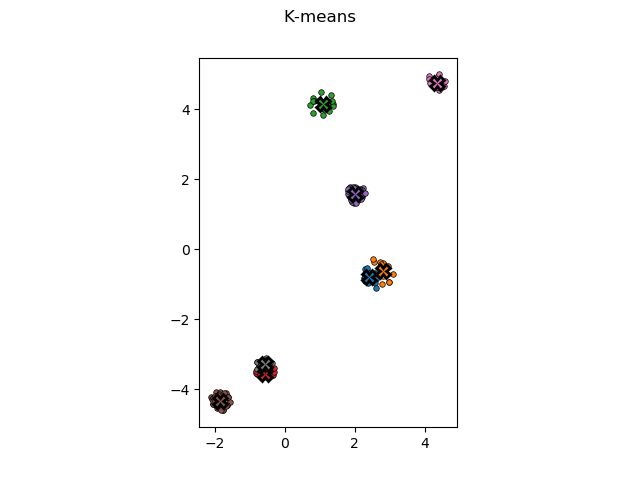

<IPython.core.display.Javascript object>


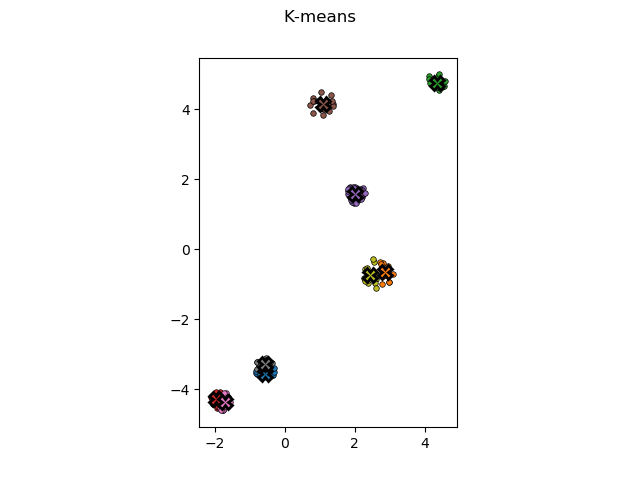

<IPython.core.display.Javascript object>


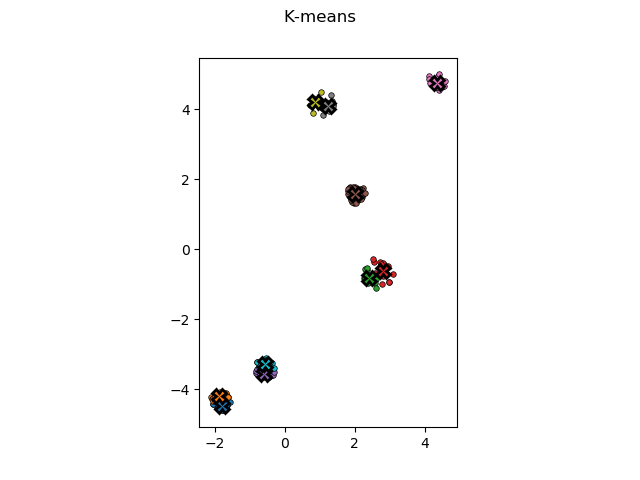

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


<IPython.core.display.Javascript object>


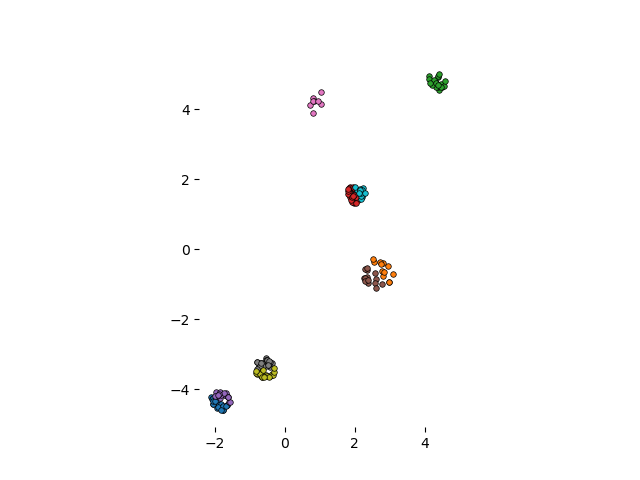

<IPython.core.display.Javascript object>


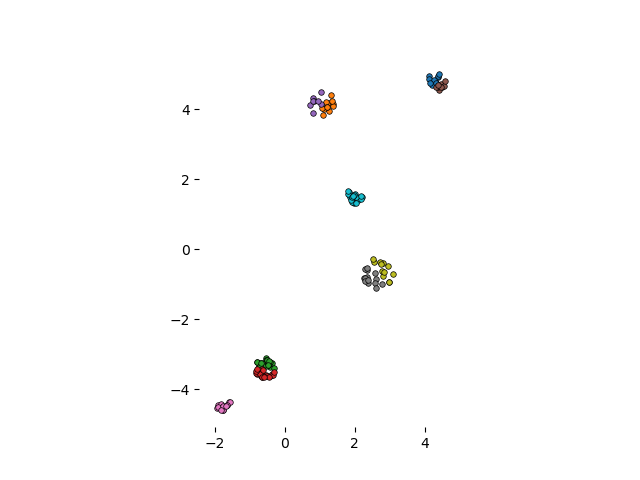

<IPython.core.display.Javascript object>


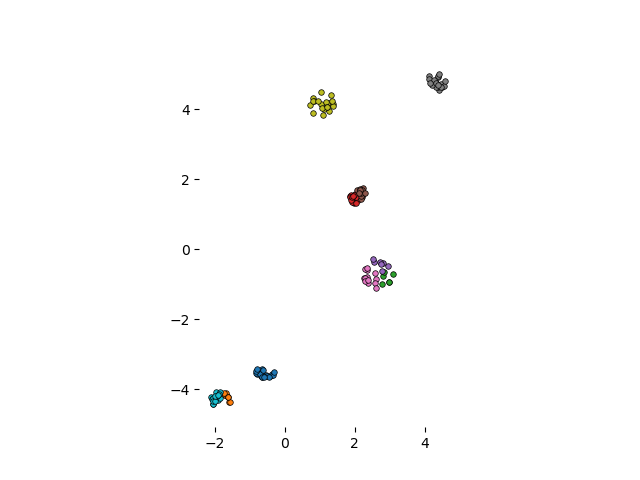

<IPython.core.display.Javascript object>


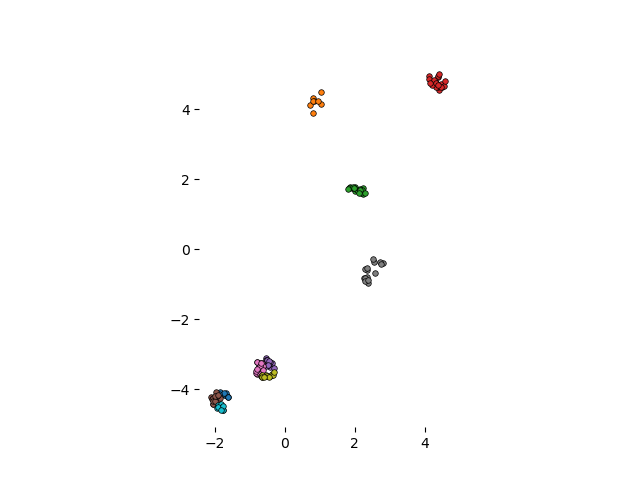

In [121]:
elbow_method(range(2, 15), points_elbow, euclidean_intra_cluster_distance, 100, 50)

<IPython.core.display.Javascript object>


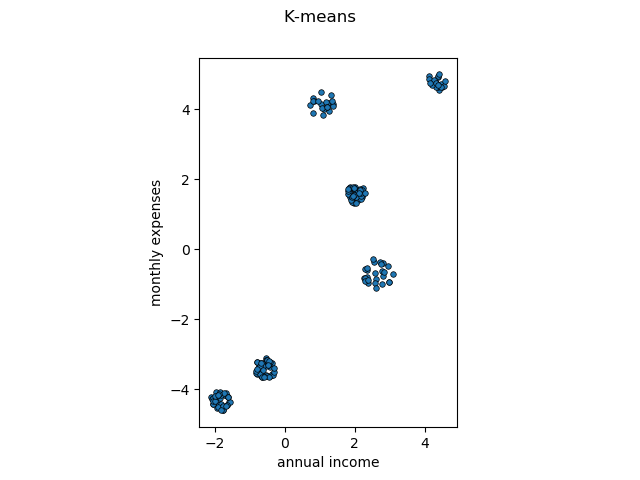

In [126]:
plot_clusters(points_elbow, [0] * len(points), [], [], 'annual income', 'monthly expenses')